# Importing the Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,RepeatVector
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
import tensorflow as tf

# Loading the Dataset

In [2]:
df = pd.read_csv('../input/frenchenglish/fra.txt' , delimiter="\t" , names = ['english' , 'french' ,'ignore'])
del df['ignore']
df.head(10)

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !
5,Who?,Qui ?
6,Wow!,Ça alors !
7,Fire!,Au feu !
8,Help!,À l'aide !
9,Jump.,Saute.


In [3]:
df.isna().sum() # Checking for nan Values

english    0
french     0
dtype: int64

In [4]:
punctuation = list(string.punctuation)
punctuation[:5]

['!', '"', '#', '$', '%']

# Basic Data Cleaning & Data Visualization

In [5]:
# Removing html text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)
# Removing punctuations, non-alphabetical characters & converting text to lowercase
def clean_text(text):
    final_text = []
    for i in word_tokenize(text):
        if i.strip().lower().isalpha() and i.strip().lower() not in punctuation:
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = clean_text(text)
    return text
#Apply function on text columns
df['english']=df['english'].apply(denoise_text)
df['french']=df['french'].apply(denoise_text)

In [6]:
df.drop_duplicates(inplace = True)
df.head(10)

,english,french
0,go,va
1,hi,salut
3,run,cours
4,run,courez
5,who,qui
6,wow,ça alors
7,fire,au feu
8,help,à
9,jump,saute
10,stop,ça suffit


**WordCloud for English Text**

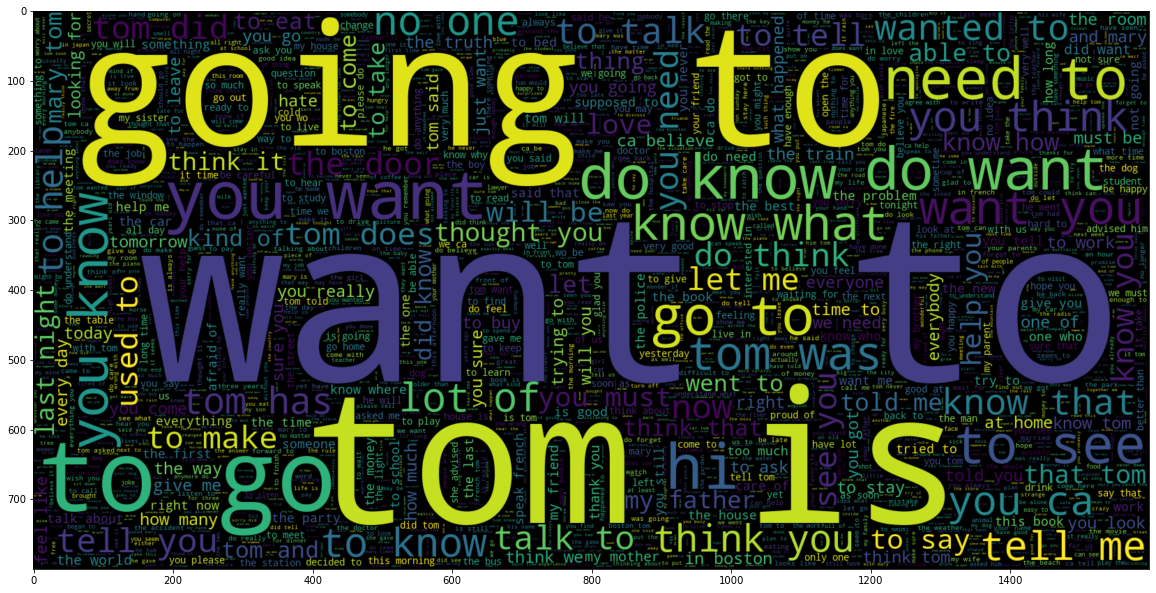

In [7]:
plt.figure(figsize = (20,20)) # English Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.english))
plt.imshow(wc , interpolation = 'bilinear')

**WordCloud for French Text**

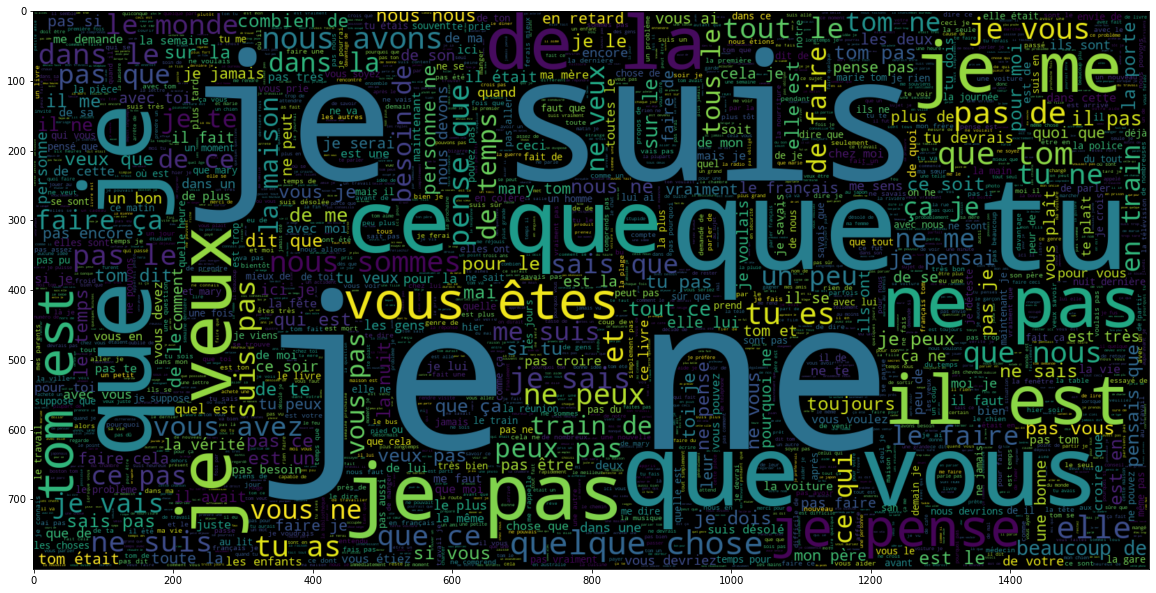

In [8]:
plt.figure(figsize = (20,20)) # French Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.french))
plt.imshow(wc , interpolation = 'bilinear')

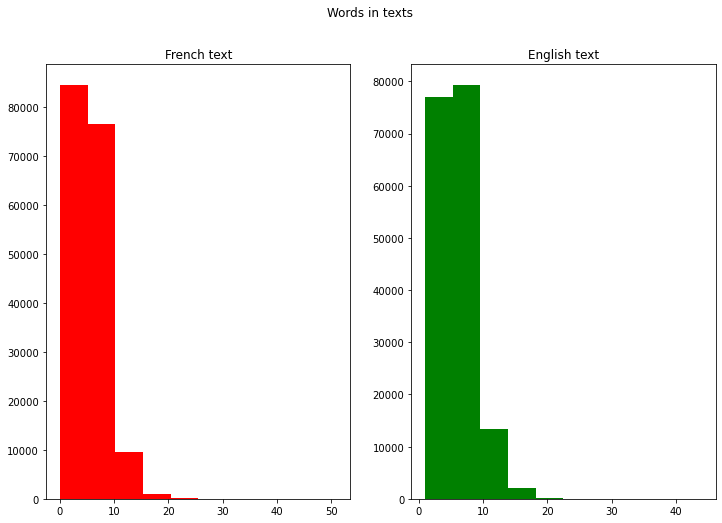

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df['french'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('French text')
text_len=df['english'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('English text')
fig.suptitle('Words in texts')
plt.show()

**Finding max length of text in both languages (English & French)**

In [10]:
fr_max,en_max = 0,0
for i in df['french'].str.split().values:
    if(len(i) > fr_max):
        fr_max = len(i)
for i in df['english'].str.split().values:
    if(len(i) > en_max):
        en_max = len(i)
print(fr_max,en_max)        

51 44


In [11]:
x_train,x_test,y_train,y_test = train_test_split(df.french.values , df.english.values , test_size = 0.1 , random_state = 0)

In [12]:
len(x_train),len(x_test)

(154802, 17201)

**Tokenization of english and french sentences**

In [14]:
fr_tokenizer = text.Tokenizer()
fr_tokenizer.fit_on_texts(x_train)
fr_tokenized_train = fr_tokenizer.texts_to_sequences(x_train)
X_train = sequence.pad_sequences(fr_tokenized_train, maxlen = fr_max , padding = 'post')

fr_tokenized_test = fr_tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(fr_tokenized_test, maxlen = fr_max , padding = 'post')

In [13]:
en_tokenizer = text.Tokenizer()
en_tokenizer.fit_on_texts(y_train)
en_tokenized_train = en_tokenizer.texts_to_sequences(y_train)
Y_train = sequence.pad_sequences(en_tokenized_train, maxlen = en_max , padding = 'post')

en_tokenized_test = en_tokenizer.texts_to_sequences(y_test)
Y_test = sequence.pad_sequences(en_tokenized_test, maxlen = en_max , padding = 'post')

In [15]:
eng_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1
print(eng_vocab_size)
print(fr_vocab_size)

13569
21956


**Initializing TPU**

In [16]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Training the Model

In [17]:
with strategy.scope():
    # Encoder
    model = Sequential()
    model.add(Embedding(fr_vocab_size, output_dim = 512, input_length = fr_max , mask_zero = True))
    model.add(Bidirectional(LSTM(units = 256 , return_sequences=True , recurrent_dropout = 0.25 , dropout = 0.25)))
    model.add(LSTM(units = 64 , recurrent_dropout = 0.1 , dropout = 0.1))
    model.add(RepeatVector(en_max))
    # Decoder
    model.add(LSTM(units = 64 , return_sequences=True , recurrent_dropout = 0.1 , dropout = 0.1))
    model.add(Bidirectional(LSTM(units = 256, return_sequences=True , recurrent_dropout = 0.25 , dropout = 0.25)))
    model.add(Dense(eng_vocab_size, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 512)           11241472  
_________________________________________________________________
bidirectional (Bidirectional (None, 51, 512)           1574912   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 44, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 44, 64)            33024     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 44, 512)           657408    
_________________________________________________________________
dense (Dense)                (None, 44, 13569)         6

In [18]:
lr_callback = ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.5 , patience = 3 , min_lr = 0.0000001)
checkpoint = ModelCheckpoint('best_model.h5', monitor = 'val_loss' , save_best_only = True)
history = model.fit(X_train, Y_train, epochs=30, batch_size=512, validation_data = (X_test,Y_test) , callbacks = [lr_callback,checkpoint])

Epoch 1/30
303/303 [==============================] - 33s 108ms/step - loss: 1.1927 - accuracy: 0.8636 - val_loss: 1.0247 - val_accuracy: 0.8709 - lr: 0.0100
Epoch 2/30
303/303 [==============================] - 21s 69ms/step - loss: 1.0303 - accuracy: 0.8704 - val_loss: 1.0087 - val_accuracy: 0.8715 - lr: 0.0100
Epoch 3/30
303/303 [==============================] - 21s 70ms/step - loss: 1.0066 - accuracy: 0.8720 - val_loss: 0.9759 - val_accuracy: 0.8758 - lr: 0.0100
Epoch 4/30
303/303 [==============================] - 21s 70ms/step - loss: 0.9717 - accuracy: 0.8771 - val_loss: 0.9413 - val_accuracy: 0.8812 - lr: 0.0100
Epoch 5/30
303/303 [==============================] - 21s 70ms/step - loss: 0.9409 - accuracy: 0.8819 - val_loss: 0.9143 - val_accuracy: 0.8849 - lr: 0.0100
Epoch 6/30
303/303 [==============================] - 21s 71ms/step - loss: 0.9169 - accuracy: 0.8848 - val_loss: 0.8920 - val_accuracy: 0.8876 - lr: 0.0100
Epoch 7/30
303/303 [==============================] - 21s

# ANALYSIS AFTER TRAINING OF MODEL & PREDICTIONS

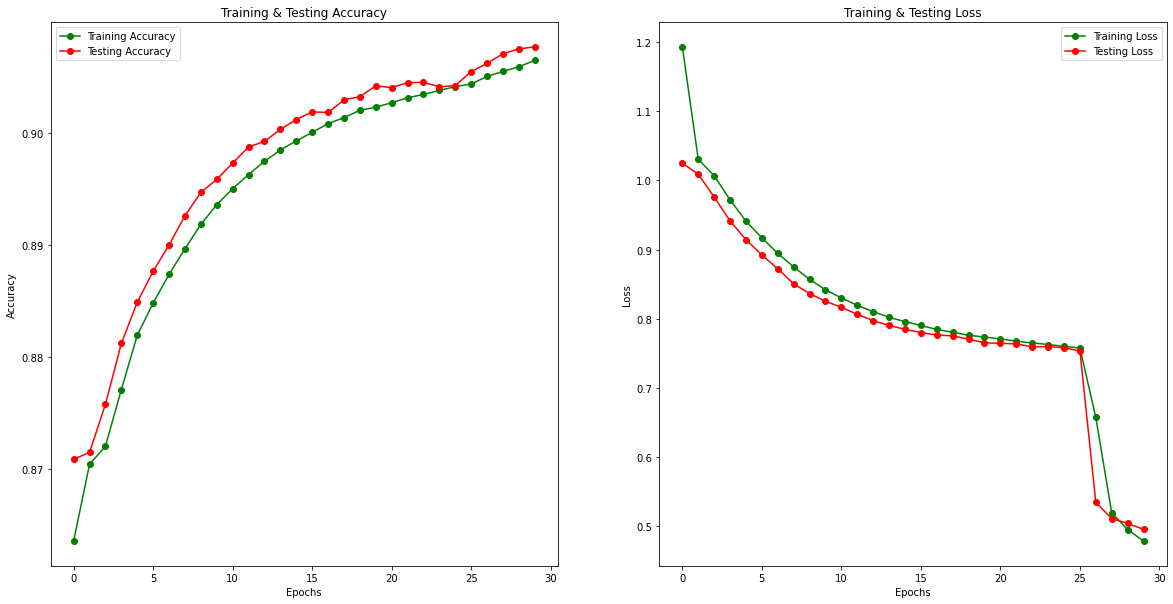

In [108]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [19]:
import gc
gc.collect();

In [20]:
from tqdm import tqdm
final_predictions = []
for i in tqdm(range(0,len(X_test),400)):
    try:
        p = model.predict_classes(X_test[i:i+400])[:400]
        final_predictions.extend(p)
    except:    
        p = model.predict_classes(X_test[i:i+400])
        final_predictions.extend(p)

100%|██████████| 44/44 [01:59<00:00,  2.72s/it]


In [23]:
final_predictions = final_predictions[:17201]
len(final_predictions)

17201

In [74]:
def get_word(n, tokenizer):
    words = list(tokenizer.word_index.keys())
    try:
        return words[n-1]
    except:
        return None
    '''for word, index in tokenizer.word_index.items():
        if index == n:
            return word'''

In [76]:
preds_text = []
for i in tqdm(final_predictions):
    temp = []
    for j in range(len(i)):
        if(i[j] == 0):
            break
        t = get_word(i[j], en_tokenizer)
        if j > 0: #If it is not the first word
            if (t == get_word(i[j-1], en_tokenizer)) or (t == None):  #if the next word is same as the previous
                temp.append('')
            else:
                temp.append(t)
             
        else: #if it's not the first word
            if(t == None): #if we didn't get a valid code from dictionary 
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

100%|██████████| 17201/17201 [00:43<00:00, 392.91it/s]


In [79]:
len(preds_text)

17201

In [80]:
pred_df = pd.DataFrame({'actual' : y_test, 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

In [85]:
pred_df.tail(10)

,actual,predicted
17191,he decided not to go,he decided not to go
17192,i do understand why it happened,i do understand why i happened
17193,you do have to go,you do have to go
17194,can you afford it,can you handle it
17195,it time for a coffee break,would you want to take a
17196,it inevitable,it was
17197,i wo eat breakfast tomorrow,i not go tomorrow
17198,she set a new world record,she got a cottage on the shelf
17199,does the room have air conditioning,is the
17200,there is no way of reaching the island other than by boat,there no to the


# Adding BLEU Scores

In [99]:
bleu_scores = []
for i in pred_df.values:
    BLEUscore = nltk.translate.bleu([i[0].split()], i[1].split())
    bleu_scores.append(BLEUscore)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [105]:
bleu_scores = np.array(bleu_scores , dtype = float)
bleu_scores.max(),bleu_scores.min(),bleu_scores.mean()

(1.0, 0.0, 0.4985697438815129)

In [107]:
pred_df['BLEU_SCORE'] = bleu_scores
pred_df.tail(10)

,actual,predicted,BLEU_SCORE
17191,he decided not to go,he decided not to go,1.000000
17192,i do understand why it happened,i do understand why i happened,0.537285
17193,you do have to go,you do have to go,1.000000
17194,can you afford it,can you handle it,0.707107
17195,it time for a coffee break,would you want to take a,0.638943
17196,it inevitable,it was,0.840896
17197,i wo eat breakfast tomorrow,i not go tomorrow,0.654891
17198,she set a new world record,she got a cottage on the shelf,0.731110
17199,does the room have air conditioning,is the,0.113803
17200,there is no way of reaching the island other than by boat,there no to the,0.125944


In [109]:
pred_df.to_csv("preds.csv" , index = False)